##Final Capstone
Introduction/Background: TalkingData, China’s largest third-party mobile data platform, is seeking to leverage behavioral data from more than 70% of the 500 million mobile devices active daily in China to help its clients better understand and interact with their audiences.

Objective:The purpose of this project is to classify a subset of the population of China that uses a mobile operator based on the apps they have installed and that they used and the brand of the device they have.The classification takes into consideration gender and age range.  

Approach: Applying Supervised Learning, Deep Learning, and Unsupervised Clustering techniques to build a model predicting users demographic characteristics based on their app usage, geolocation, & mobile device properties. 

Motivation: To help stakeholders pursue data-driven marketing efforts relevant and catered to their users preferences.

In [67]:
# Load the libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.cluster import SpectralClustering, MeanShift, estimate_bandwidth, AffinityPropagation, KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict, GridSearchCV, StratifiedKFold
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Input
from tensorflow.keras import optimizers
from keras.optimizers import SGD, RMSprop
from keras import backend as K
%matplotlib inline

###Data Wrangling/ Data Cleaning

Created a dataset that combined the different files. Carried out a set of merging actions based on the information provided and combined with cleaning to avoid oversizing the final dataset prior to the features generation.

To merge this information the hypothesis around the potential features that can explain the demographics of the users for further classification has been used: appa events, app labels, events, device brands, gender and age. This transforms the problem into selecting and generation the categorical features (predictors) to determine based on them if the user is in a certain age range and gender (target).

The order in which the different datasets are merged is not random. Several ways of merging the data have been tried and this is the one that allows to build a model that will predict the age range and gender gathering as much relevant information as possible.The dataset provided by Kaggle as the test in the abovementioned link has been discarded as it is providing devices that are not contained in the training dataset and is adding noise to the dataset as we don´t have any relevant information from which we can create features.

In [68]:
# Load the datasets
app_events = pd.read_csv('/content/drive/My Drive/app_events.csv')
app_labels = pd.read_csv('/content/drive/My Drive/app_labels.csv')
events = pd.read_csv('/content/drive/My Drive/events.csv')
gender_age_test = pd.read_csv('/content/drive/My Drive/gender_age_test.csv')
gender_age_train = pd.read_csv('/content/drive/My Drive/gender_age_train.csv')
phone_brand_device_model = pd.read_csv('/content/drive/My Drive/phone_brand_device_model.csv')

The appevents dataset links the events or usage of the different apps to the app id that categorizes the apps within certain groups such as gaming, finance, etc. In this case the app ides will be used as a categorical features to have a better description of the interests of the target audience. The linking column will be the events as it appears in both datasets (app_events and device apps) including information about the app to see if it is active or just installed.

In [69]:
app_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   event_id      int64
 1   app_id        int64
 2   is_installed  int64
 3   is_active     int64
dtypes: int64(4)
memory usage: 991.0 MB


In [70]:
# Drop is_installed from app_events
app_events = app_events.drop(columns='is_installed')

The applabels dataset “translates” a 20 digits id into the abovementioned categories.

In [71]:
app_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   app_id    459943 non-null  int64
 1   label_id  459943 non-null  int64
dtypes: int64(2)
memory usage: 7.0 MB


The events dataset gives information about the location and the time in which the app is used in the device. In this case the information about the location has been discarded as it is not accurate giving as locations points outside of China hence not adding relevant information for the features generation.

In [72]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252950 entries, 0 to 3252949
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   event_id   int64  
 1   device_id  int64  
 2   timestamp  object 
 3   longitude  float64
 4   latitude   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 124.1+ MB


In [73]:
# Drop timestamp, longitude, latitude from events
events = events.drop(columns='timestamp')
events = events.drop(columns='longitude')
events = events.drop(columns='latitude')

In [74]:
gender_age_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112071 entries, 0 to 112070
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   device_id  112071 non-null  int64
dtypes: int64(1)
memory usage: 875.7 KB


In [75]:
gender_age_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device_id  74645 non-null  int64 
 1   gender     74645 non-null  object
 2   age        74645 non-null  int64 
 3   group      74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


The phone brand dataset is linking the device id with the phone brand and model. The device model will be used and grouped by phone brand to use it as one of the features. In this case and for further merging of the datasets the duplicates in phone brands have been dropped as it will increase the dataset making it unmanageable not adding information.

In [76]:
phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187245 entries, 0 to 187244
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   device_id     187245 non-null  int64 
 1   phone_brand   187245 non-null  object
 2   device_model  187245 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [77]:
# Get rid of duplicate device ids in phone brand device model
phone_brand_device_model = phone_brand_device_model.drop_duplicates('device_id',keep='first')

In [78]:
#Merge the app_events and events to access app_ids.
device_apps = (
  app_events.merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
  # Drop event_id as it is not interesting
  .drop(columns = 'event_id')
  # Because the events correspond to more than just
  # being installed, there are many duplicates
  .drop_duplicates())

In [79]:
device_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2840343 entries, 0 to 32472919
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   app_id     int64
 1   is_active  int64
 2   device_id  int64
dtypes: int64(3)
memory usage: 86.7 MB


In [80]:
device_apps.head()

,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


In this case the information about events (usage of the phone) and app_events that identifies app ids is merged using as the merging column the events. As a result information about the device id the use of the app and the app id are in the same dataframe which allows further merging to arrive to the applabels and device brands. In this merging the duplicates have been left out to avoid oversizing the dataframe. From the information of this dataset there are 459k rows of data that match usage, device id to app id. The timestamp has been eliminated from the dataset as it does not add relevant information and there are data points missing.

In [81]:
labels_apps = (
    device_apps
    
     # Merge on event_id
    .merge(app_labels, how = 'left', left_on = 'app_id', right_on = 'app_id')
    
     # event_id itself is not interesting
    .drop('app_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

In [82]:
#Clean the dataset removing empty cells from the data set
labels_apps = labels_apps.dropna()

#convert first or second to str or int
labels_apps['device_id'] = labels_apps['device_id'].astype(int)

#Merge the column back into the dataset
gender_age_train['device_id'] = gender_age_train['device_id'].astype(int)

In [83]:
labels_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5977729 entries, 0 to 18279373
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   is_active  int64
 1   device_id  int64
 2   label_id   int64
dtypes: int64(3)
memory usage: 182.4 MB


In [84]:
labels_apps.head()

,is_active,device_id,label_id
0,1,-6401643145415154744,549
1,1,-6401643145415154744,710
2,1,-6401643145415154744,704
3,1,-6401643145415154744,548
4,1,-6401643145415154744,172


The dataset containing data about the usage of the apps, the activity, device id is linked with the dataset containing the device id and information about the gender, age and age group. The age groups used are the ones provided in the dataset and have not been changed.

There are 12 groups that differentiate the age and gender. The groups roughly split the population in even groups and the distribution of data points for each group is shown in the following graph.

In [85]:
#Merge the app_events and events to access app_ids.
gender_labels_apps = (
    labels_apps.merge(gender_age_train, how = 'left', left_on = 'device_id', right_on = 'device_id')
   
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

In [86]:
gender_labels_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5977729 entries, 0 to 5977728
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   is_active  int64  
 1   device_id  int64  
 2   label_id   int64  
 3   gender     object 
 4   age        float64
 5   group      object 
dtypes: float64(1), int64(3), object(2)
memory usage: 319.2+ MB


In [87]:
#Identify null values
gender_labels_apps.isnull().sum()

is_active          0
device_id          0
label_id           0
gender       3663482
age          3663482
group        3663482
dtype: int64

In [88]:
#Drop null values
gender_labels_apps = gender_labels_apps.dropna()

In [89]:
#Reset index in the new dataset
gender_labels_apps.reset_index(drop= True)

,is_active,device_id,label_id,gender,age,group
0,1,1476664663289716375,549,M,19.0,M22-
1,1,1476664663289716375,721,M,19.0,M22-
2,1,1476664663289716375,704,M,19.0,M22-
3,1,1476664663289716375,302,M,19.0,M22-
4,1,1476664663289716375,303,M,19.0,M22-
...,...,...,...,...,...,...
2314242,1,-3073329096930708245,209,F,33.0,F33-42
2314243,1,-2180577908480078273,215,M,44.0,M39+
2314244,1,-2180577908480078273,1014,M,44.0,M39+
2314245,0,-2180577908480078273,706,M,44.0,M39+


###Exploratory Data Analysis (EDA)/ Data Visualization

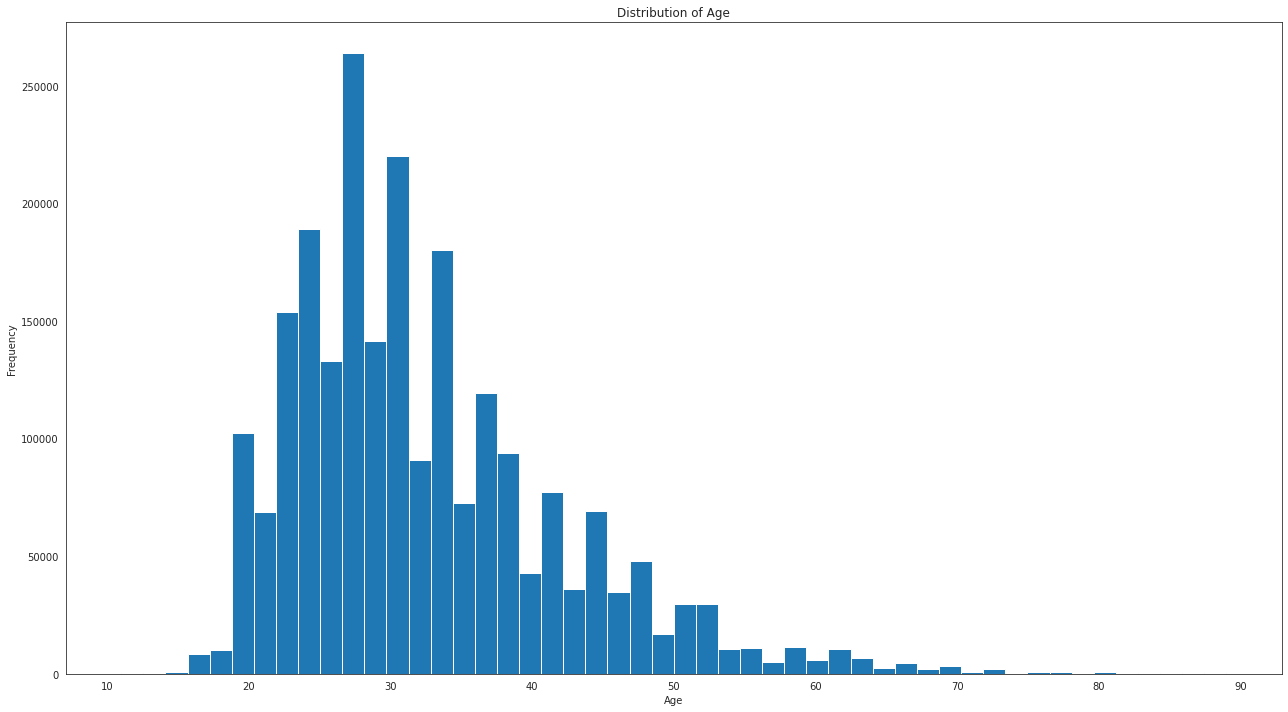

In [ ]:
#Plot the distribution of age in the dataset

plt.figure(figsize=(18, 10))
gender_labels_apps.age.hist(bins=50, grid = False)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Visual inspection of the distribution of data between ages show that the data is skewed to the right, showing that most of the data represents the age group between 20 and 35 years old. This corresponds to the grouping that has been done age-wise.

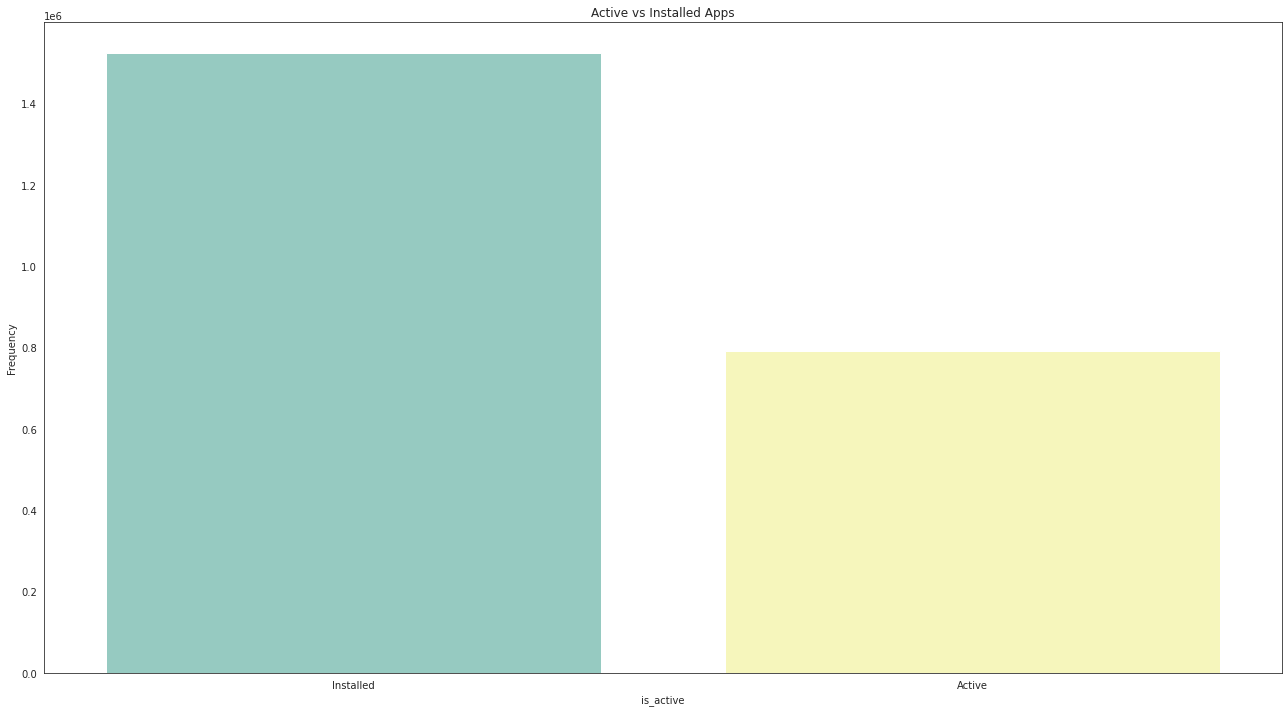

In [ ]:
#Plot installed vs active apps

plt.figure(figsize=(18, 10))
sns.set_style("white")
ax = sns.countplot(x="is_active", data=gender_labels_apps, palette="Set3")
ax.set_title('Active vs Installed Apps')
ax.set_ylabel('Frequency')
ax.set_xticklabels(['Installed','Active'], fontsize=10)
plt.tight_layout()
plt.show()

In the Chinese market the number of apps that is actively used from the ones installed in the devices equate to roughly 50%.

Before adding the data for phone brands and models, a dictionary is taken from Kaggle to translate the brands from Chinese to English. Additionally, for those brands with no translation add “NoBrandXX” where XX for two digits. 

In [90]:
english_translation_phone_brands = {"三星": "samsung","天语": "Ktouch", "海信": "hisense", "联想": "lenovo", "欧比": "obi",
                                "爱派尔": "ipair", "努比亚": "nubia", "优米": "youmi", "朵唯": "dowe", "黑米": "heymi",
                                "锤子": "hammer", "酷比魔方": "koobee", "美图": "meitu", "尼比鲁": "nibilu", "一加": "oneplus",
                                "优购": "yougo", "诺基亚": "nokia", "糖葫芦": "candy", "中国移动": "ccmc", "语信": "yuxin",
                                "基伍": "kiwu", "青橙": "greeno", "华硕": "asus", "夏新": "panasonic", "维图": "weitu",
                                "艾优尼": "aiyouni", "摩托罗拉": "moto", "乡米": "xiangmi", "米奇": "micky", "大可乐": "bigcola",
                                "沃普丰": "wpf", "神舟": "hasse", "摩乐": "mole", "飞秒": "fs", "米歌": "mige", "富可视": "fks",
                                "德赛": "desci", "梦米": "mengmi", "乐视": "lshi", "小杨树": "smallt", "纽曼": "newman",
                                "邦华": "banghua", "E派": "epai", "易派": "epai", "普耐尔": "pner", "欧新": "ouxin", "西米": "ximi",
                                "海尔": "haier", "波导": "bodao", "糯米": "nuomi", "唯米": "weimi", "酷珀": "kupo", "谷歌": "google",
                                "昂达": "ada", "聆韵": "lingyun", "小米": "Xiaomi", "华为": "Huawei", "魅族": "Meizu", "中兴": "ZTE",
                                "酷派": "Coolpad", "金立": "Gionee", "SUGAR": "SUGAR", "OPPO": "OPPO", "vivo": "vivo", "HTC": "HTC",
                                "LG": "LG", "ZUK": "ZUK", "TCL": "TCL", "LOGO": "LOGO", "SUGAR": "SUGAR", "Lovme": "Lovme",
                                "PPTV": "PPTV", "ZOYE": "ZOYE", "MIL": "MIL", "索尼" : "Sony", "欧博信" : "Opssom", "奇酷" : "Qiku",
                                "酷比" : "CUBE", "康佳" : "Konka", "亿通" : "Yitong", "金星数码" : "JXD", "至尊宝" : "Monkey King",
                                "百立丰" : "Hundred Li Feng", "贝尔丰" : "Bifer", "百加" : "Bacardi", "诺亚信" : "Noain", 
                                "广信" : "Kingsun", "世纪天元" : "Ctyon", "青葱" : "Cong", "果米" : "Taobao", "斐讯" : "Phicomm",
                                "长虹" : "Changhong", "欧奇" : "Oukimobile", "先锋" : "XFPLAY", "台电" : "Teclast", "大Q" : "Daq",
                                "蓝魔" : "Ramos", "奥克斯" : "AUX", "索尼" : "Sony", "欧博信" : "Opssom", "奇酷" : "Qiku",
                                "酷比" : "CUBE", "康佳" : "Konka", "亿通" : "Yitong", "金星数码" : "JXD", "至尊宝" : "Monkey King",
                                "百立丰" : "Hundred Li Feng", "贝尔丰" : "Bifer", "百加" : "Bacardi", "诺亚信" : "Noain",
                                "广信" : "Kingsun", "世纪天元" : "Ctyon", "青葱" : "Cong", "果米" : "Taobao", "斐讯" : "Phicomm",
                                "长虹" : "Changhong", "欧奇" : "Oukimobile", "先锋" : "XFPLAY", "台电" : "Teclast", "大Q" : "Daq", 
                                "蓝魔" : "Ramos", "奥克斯" : "AUX", "飞利浦": "Philips", "智镁": "Zhimei", "惠普": "HP",
                                "原点": "Origin", "戴尔": "Dell", "碟米": "Diemi", "西门子": "Siemens", "亚马逊": "Amazon",
                                "宏碁": "Acer",
                                '世纪星': "NoBrand1", '丰米': "NoBrand2", '优语':'NoBrand3', '凯利通': "NoBrand4", '唯比': "NoBrand5", '嘉源': "NoBrand6",
                                 '大显': "NoBrand7", '天宏时代': "NoBrand8", '宝捷讯': 'NoBrand9','帷幄': 'NoBrand10', '德卡诺': 'NoBrand11',
                                '恒宇丰': 'NoBrand12', '本为': 'NoBrand13', '极米': 'NoBrand14', '欧乐迪': 'NoBrand15', '欧乐酷': 'NoBrand16',
                                '欧沃': 'NoBrand17', '瑞米': 'NoBrand18', '瑞高': 'NoBrand19', '白米': 'NoBrand20', '虾米': 'NoBrand21', '赛博宇华': 'NoBrand22',
                                '首云': 'NoBrand23', '鲜米': 'NoBrand24'}

The phone brands dataset has been added to the previous dataset containing all the information about apps, age, gender, etc. In the instances in which the device id does not appear the NaN results have been filled in with zeros. The devices that are duplicate have been deleted to make the dataset manageable from a computing perspective reducing from two million rows to 23k data rows. The device id and device model columns have been dropped as in further research they were not adding information for the feature generation. Additionally, a dummy variable has been created for the variable gender.

In [91]:
#Replace phone brands in Chinese with English
phone_brand_device_model['phone_brand'].replace(english_translation_phone_brands, inplace=True)

In [92]:
#Drop the device model column as it is not adding information
phone_brand_device_model = phone_brand_device_model.drop(columns='device_model')

In [93]:
phone_brand_device_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186716 entries, 0 to 187243
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   device_id    186716 non-null  int64 
 1   phone_brand  186716 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [94]:
phone_brand_device_model.head()

,device_id,phone_brand
0,-8890648629457979026,Xiaomi
1,1277779817574759137,Xiaomi
2,5137427614288105724,samsung
3,3669464369358936369,SUGAR
4,-5019277647504317457,samsung


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0, flags=flags)


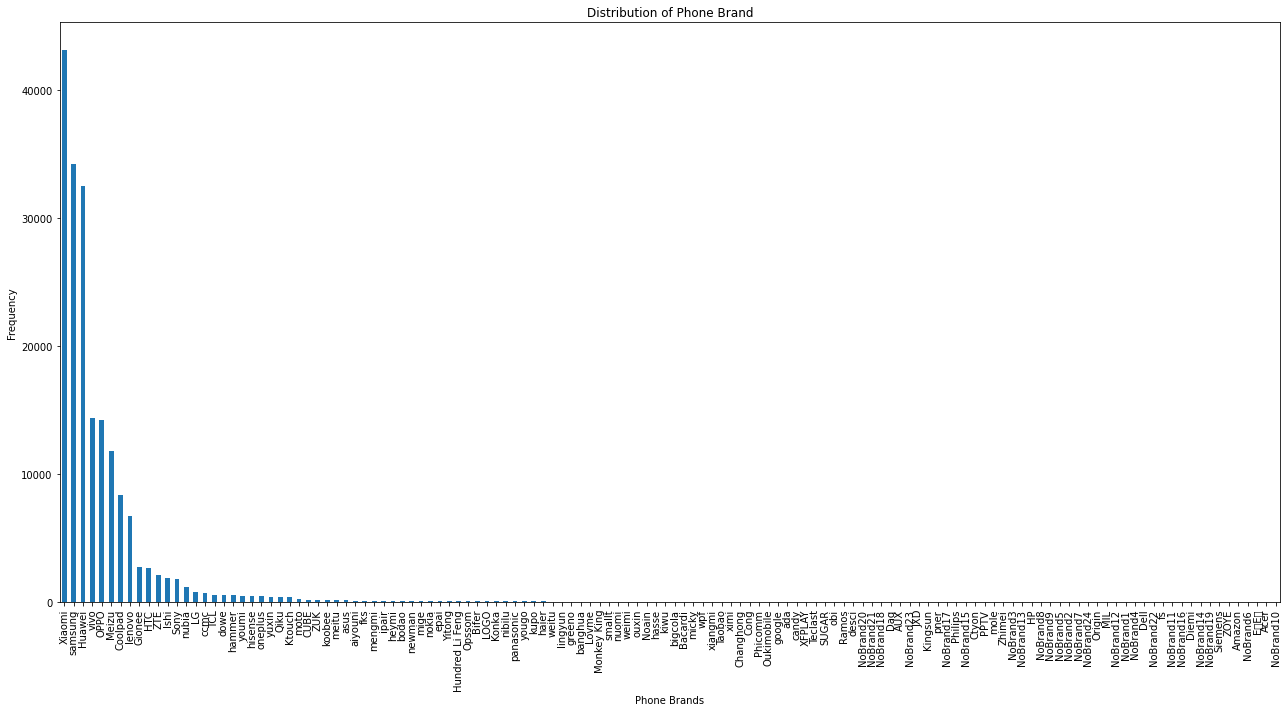

In [30]:
#Plot the distribution of phone brand

plt.figure(figsize=(18, 10))
phone_brand_device_model.phone_brand.value_counts().plot(kind='bar', grid=False)
plt.title('Distribution of Phone Brand')
plt.xlabel('Phone Brands')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As it is shown in the graph above, eight brands represent 90% of the sample in the Chinese market.

Dummy variables are created based on the apps that are installed on the devices. In this case 484 additional columns are created with categorical data that counts the appearance of each app category in the device. To avoid the dummy variable trap whereby collinearity exists between the variables one redundant category is dropped when transforming the categorical variables into dummies.

In [95]:
# Create dummy variables for gender_labels_apps
df_dummies = pd.get_dummies(gender_labels_apps, columns = ['label_id'], sparse = True).reset_index(drop= True)

In [96]:
df_dummies.head()

,is_active,device_id,gender,age,group,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,label_id_9,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,label_id_17,label_id_18,label_id_19,label_id_20,label_id_21,label_id_22,label_id_23,label_id_24,label_id_25,label_id_26,label_id_27,label_id_29,label_id_30,label_id_31,label_id_32,label_id_33,label_id_35,label_id_36,label_id_37,label_id_38,label_id_39,label_id_40,label_id_41,...,label_id_973,label_id_974,label_id_975,label_id_976,label_id_977,label_id_978,label_id_980,label_id_982,label_id_983,label_id_984,label_id_986,label_id_987,label_id_988,label_id_990,label_id_991,label_id_993,label_id_995,label_id_996,label_id_997,label_id_998,label_id_999,label_id_1002,label_id_1003,label_id_1005,label_id_1006,label_id_1007,label_id_1008,label_id_1009,label_id_1010,label_id_1011,label_id_1012,label_id_1013,label_id_1014,label_id_1015,label_id_1016,label_id_1017,label_id_1018,label_id_1019,label_id_1020,label_id_1021
0,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [97]:
# Create dummy variables for gender_labels_apps
phone_brand_dummies = pd.get_dummies(phone_brand_device_model, columns = ['phone_brand'], sparse = True).reset_index(drop= True)

In [98]:
#Create the final dataset
#Merge the demographic dataset with the phone dataset
df = (
    df_dummies
    
     # Merge on event_id
    .merge(phone_brand_dummies, how = 'left', left_on = 'device_id', right_on = 'device_id')
    
     # event_id itself is not interesting
    .fillna(0))

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314247 entries, 0 to 2314246
Columns: 620 entries, is_active to phone_brand_yuxin
dtypes: Sparse[int64, 0](615), float64(1), int64(2), object(2)
memory usage: 158.9+ MB


In [100]:
#Drop from the final dataset duplicates for the devices keeping the first one
df = df.drop_duplicates('device_id',keep= 'first').reset_index(drop=True)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 620 entries, is_active to phone_brand_yuxin
dtypes: Sparse[int64, 0](615), float64(1), int64(2), object(2)
memory usage: 1.4+ MB


In [102]:
df.head()

,is_active,device_id,gender,age,group,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,label_id_9,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,label_id_17,label_id_18,label_id_19,label_id_20,label_id_21,label_id_22,label_id_23,label_id_24,label_id_25,label_id_26,label_id_27,label_id_29,label_id_30,label_id_31,label_id_32,label_id_33,label_id_35,label_id_36,label_id_37,label_id_38,label_id_39,label_id_40,label_id_41,...,phone_brand_greeno,phone_brand_haier,phone_brand_hammer,phone_brand_hasse,phone_brand_heymi,phone_brand_hisense,phone_brand_ipair,phone_brand_kiwu,phone_brand_koobee,phone_brand_kupo,phone_brand_lenovo,phone_brand_lingyun,phone_brand_lshi,phone_brand_meitu,phone_brand_mengmi,phone_brand_micky,phone_brand_mige,phone_brand_mole,phone_brand_moto,phone_brand_newman,phone_brand_nibilu,phone_brand_nokia,phone_brand_nubia,phone_brand_nuomi,phone_brand_obi,phone_brand_oneplus,phone_brand_ouxin,phone_brand_panasonic,phone_brand_pner,phone_brand_samsung,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7166563712658305181,M,60.0,M39+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,-3449419341168524142,M,28.0,M27-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,-6542093539413689868,M,26.0,M23-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,-5638521260975573107,M,22.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The Final dataset has been created. The target variables that groups gender and age “group” has been transformed into numbers so that supervised algorithms are used for prediction.

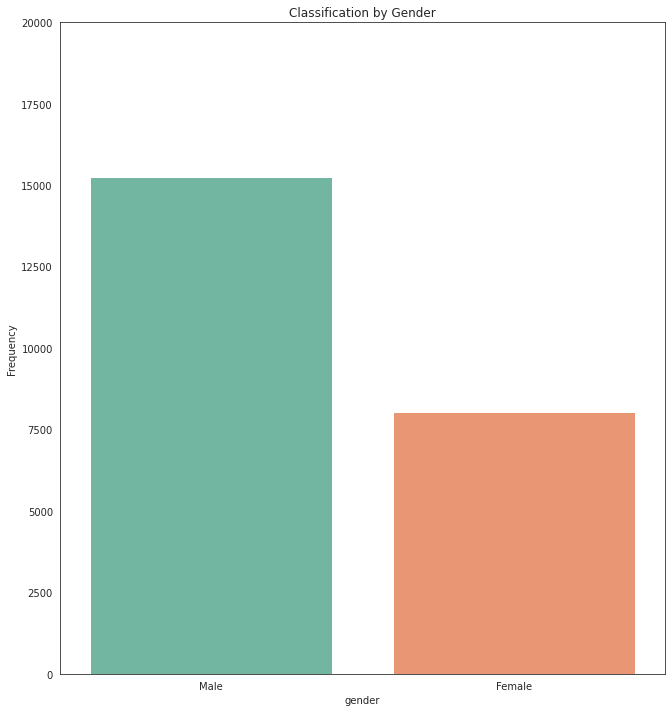

In [ ]:
# Visualize the classification by Gender
plt.figure(figsize=(18, 10))
sns.set_style("white")

plt.subplot(1, 2, 1)
ax = sns.countplot(x="gender", data=df, palette="Set2")
ax.set_title('Classification by Gender')
ax.set_ylabel('Frequency')
ax.set_xticklabels(['Male','Female'], fontsize=10)
plt.ylim(0, 20000)

plt.tight_layout()
plt.show()

The gender split in the data is not even, being more male than women in the customer base of the company. This has an impact in the further segmentation by age (including gender) expecting groups that have a lower number of data points in the case it is for women. A visual inspection of the groups show that the groups are unbalanced. This will impact the accuracy of the models for classification purposes. Further resampling is required and in this case, up-sampling will be considered using the number of samples in the largest group: males (3338 samples).

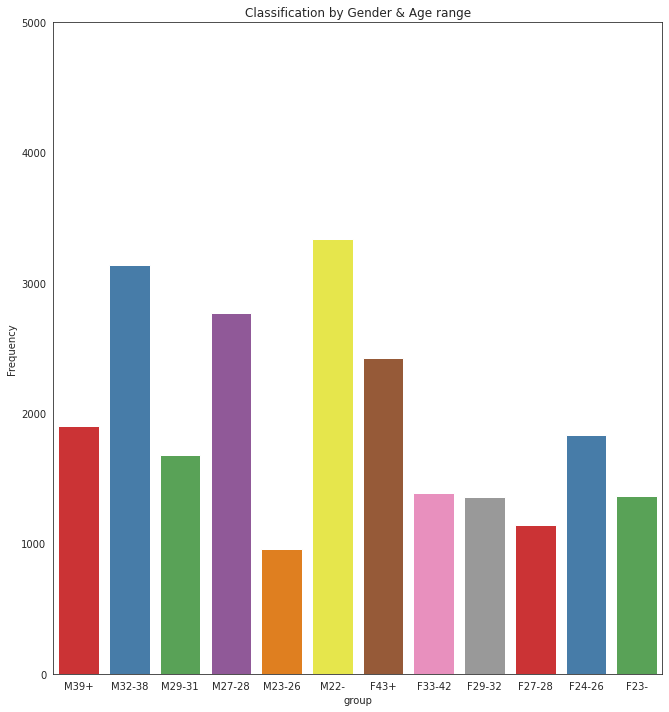

In [ ]:
# Visualize the classification by Gender and Age range
plt.figure(figsize=(18, 10))
sns.set_style("white")

plt.subplot(1, 2, 2)
ax = sns.countplot(x="group", data=df, palette="Set1")
ax.set_title('Classification by Gender & Age range')
ax.set_ylabel('Frequency')
ax.set_xticklabels(['M39+','M32-38', 'M29-31', 'M27-28', 'M23-26','M22-','F43+','F33-42', 'F29-32', 'F27-28', 'F24-26', 'F23-'], fontsize=10)
plt.ylim(0, 5000)

plt.tight_layout()
plt.show()

As the different groups are not balanced, the minority groups are balanced resampling the data and up-sampling the minority groups. This will allow the different algorithms to achieve a better accuracy in general. Some algorithms are highly sensitive to unbalanced groups in the output variable.

In [40]:
#Count number of datapoints to check class imbalancing.
print(df['group'].value_counts())

M32-38    3338
M39+      3137
M23-26    2770
M29-31    2423
M22-      1901
F33-42    1832
M27-28    1682
F29-32    1387
F23-      1365
F43+      1357
F24-26    1140
F27-28     958
Name: group, dtype: int64


In [41]:
# Upsample minority classes
# Separate majority and minority classes
df_majority = df[df.group=='M32-38']

#Minorty classes
df_minority_1 = df[df.group=='M39+']
df_minority_2 = df[df.group=='M23-26']
df_minority_3 = df[df.group=='M29-31']
df_minority_4 = df[df.group=='M22-']
df_minority_5 = df[df.group=='F33-42']
df_minority_6 = df[df.group=='M27-28']
df_minority_7 = df[df.group=='F29-32']
df_minority_8 = df[df.group=='F23-']
df_minority_9 = df[df.group=='F43+']
df_minority_10 = df[df.group=='F24-26']
df_minority_11 = df[df.group=='F27-28']

In [42]:
# Upsample minority classes
df_upsampled_1 = resample(df_minority_1, replace=True, n_samples=3338, random_state=42) 
df_upsampled_2 = resample(df_minority_2, replace=True, n_samples=3338, random_state=42)
df_upsampled_3 = resample(df_minority_3, replace=True, n_samples=3338, random_state=42)
df_upsampled_4 = resample(df_minority_4, replace=True, n_samples=3338, random_state=42)
df_upsampled_5 = resample(df_minority_5, replace=True, n_samples=3338, random_state=42)
df_upsampled_6 = resample(df_minority_6, replace=True, n_samples=3338, random_state=42)
df_upsampled_7 = resample(df_minority_7, replace=True, n_samples=3338, random_state=42)
df_upsampled_8 = resample(df_minority_8, replace=True, n_samples=3338, random_state=42)
df_upsampled_9 = resample(df_minority_9, replace=True, n_samples=3338, random_state=42)
df_upsampled_10 = resample(df_minority_10, replace=True, n_samples=3338, random_state=42)
df_upsampled_11 = resample(df_minority_11, replace=True, n_samples=3338, random_state=42)

In [43]:
# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_upsampled_1, df_upsampled_2, df_upsampled_3, df_upsampled_4, df_upsampled_5, df_upsampled_6, df_upsampled_7, df_upsampled_8,
                        df_upsampled_9, df_upsampled_10, df_upsampled_11])

In [44]:
# Display new class counts
df_upsampled.group.value_counts()

F23-      3338
M23-26    3338
F43+      3338
F24-26    3338
F29-32    3338
M29-31    3338
F27-28    3338
M27-28    3338
M32-38    3338
M39+      3338
F33-42    3338
M22-      3338
Name: group, dtype: int64

In [45]:
#Get dummy variables for the gender variable and reset index
df = pd.get_dummies(df_upsampled, columns = ['gender'], sparse = True,).reset_index(drop= True)

In [46]:
#Delete column with device_id
df = df.drop(columns='device_id')

In [47]:
#Delete columns that are all zeros
df = df.drop(df.columns[(df == 0).all()], axis = 1)

In [48]:
#Substitute the categorical output variable 
df['group'] = df['group'].map({'M39+' :0,'M32-38':1, 'M29-31':2, 'M27-28':3, 'M23-26':4,'M22-': 5,
                                           'F43+' :6,'F33-42':7, 'F29-32':8, 'F27-28':9, 'F24-26':10, 'F23-':11 })

In [49]:
# Check the first 5 rows of the data frame
df.head()

,is_active,age,group,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,label_id_17,label_id_22,label_id_24,label_id_26,label_id_27,label_id_29,label_id_30,label_id_31,label_id_32,label_id_33,label_id_35,label_id_36,label_id_38,label_id_39,label_id_40,label_id_42,label_id_43,label_id_44,label_id_46,label_id_47,label_id_51,label_id_54,label_id_57,label_id_58,label_id_59,label_id_61,label_id_64,label_id_66,label_id_69,...,phone_brand_dowe,phone_brand_epai,phone_brand_fks,phone_brand_google,phone_brand_haier,phone_brand_hammer,phone_brand_hasse,phone_brand_hisense,phone_brand_ipair,phone_brand_kiwu,phone_brand_koobee,phone_brand_kupo,phone_brand_lenovo,phone_brand_lingyun,phone_brand_lshi,phone_brand_meitu,phone_brand_mengmi,phone_brand_micky,phone_brand_moto,phone_brand_newman,phone_brand_nibilu,phone_brand_nokia,phone_brand_nubia,phone_brand_nuomi,phone_brand_obi,phone_brand_oneplus,phone_brand_ouxin,phone_brand_panasonic,phone_brand_samsung,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin,gender_F,gender_M
0,1,35.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,34.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,36.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,35.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,33.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [50]:
#Build the predictors and target variables
X = df.drop('group',axis = 1)
y = df.group

#Normalize the data
names = X.columns
X_normalized = pd.DataFrame(normalize(X), columns = names)

In [51]:
#Check shape of X_normalized and y
print(X.shape, y.shape)

#Print the groups in y
print(y.unique())

(40056, 276) (40056,)
[ 1  0  4  2  5  7  3  8 11  6 10  9]


In [52]:
#Split the dataset into a training and testing dataset as 75% and 25%
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y,test_size=0.25, random_state=42)

The dataset has been split into predictors and target variable and the dataset split into a train and test data set (75/25) defining five folds for cross validation. This train test split will be used for the feature extraction.

###Feature Engineering

Use SelectKbest method to select top features 

In [53]:
#Use SelectKBest Feature extraction. Fit the model
test = SelectKBest()
fit = test.fit(X_normalized, y)

In [54]:
#Identify features with highest scores 
names = X_normalized.columns

In [55]:
#Put the features and scores into a dataframe.
K_best_features = pd.DataFrame(fit.scores_, index = names).reset_index()
K_best_features.columns = ['SelectKBest Features', 'Scores']

In [56]:
#Show the features in descending order 
K_best_features.sort_values(by=['Scores'], ascending=False)

,SelectKBest Features,Scores
275,gender_M,453236.090993
274,gender_F,426838.209522
1,age,16256.784842
117,label_id_549,190.693682
0,is_active,182.656237
...,...,...
205,phone_brand_Lovme,0.909896
30,label_id_51,0.909531
247,phone_brand_kupo,0.909342
50,label_id_140,0.882549


In [57]:
#Select all the features that have scores higher than 1.
Top_K_best_features = K_best_features.loc[K_best_features['Scores'] > 1]['SelectKBest Features'].tolist()

Due to the characteristics of the variables the use of all the features create a lot of noise when the supervised models are run, there is overfitting in all cases. Hence, the number of variables is reduced using SelectKKbest using only those that have an explanatory power higher than 1. A dataframe is created with this new set of features.

In [58]:
#Create a dataframe with the new features
columns = Top_K_best_features
X_best_features = pd.DataFrame(X_normalized, columns = columns).reset_index(drop= True)

In [59]:
X_best_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40056 entries, 0 to 40055
Columns: 240 entries, is_active to gender_M
dtypes: float64(240)
memory usage: 73.3 MB


PCA Analysis

The variables selected by Kbest are transformed using PCA analysis.From the PCA analysis below the the PCA features are created to maximize accuracy.

In [60]:
#PCA features
from sklearn.decomposition import PCA

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform
X_std = X_best_features 

pca = PCA(n_components=5)

# Fit the PCA and transform the data
X_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_pca.shape

(40056, 5)

###Supervised Learning
The dataset is split 75/25 train test and several Supervised Learning models will be tuned in the training set and run on the test set calculating their accuracy using cross validation. The purpose of this is to train and test the classification models avoiding overfitting, exposing the algorithms to unknown data in the test set. The cross validation will be done using five folds. The data has been resampled so the representation of each class is even across folds avoiding the need to stratify the data, and reducing the bias and variance effects if classes were not evenly distributed in the dataset.

Further, all models' hyperparameters will be tuned in the training set using cross validation and gridsearch tuning several hyper parameters.

All classes have been transformed from their original categorical tag to values from 0 to 11 to enable classification.

The time required to fit the model and run the cross validation using five folds will be used to indicate the computational effort of each model.

In [127]:
#Split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)

In [128]:
#KFold for cross validation analysis
kf = KFold(5)

Logistic Regression Model

The first model to be run is the Logistic Regression model. The following hyperparameters of the model have been tuned using searchgridCV and the overall accuracy as the selection strategy:

Parameter "C" will be tuned in the training set. Lower values of C parameter will show a higher regularization.
The model is initialized and several values are tested. The solver is set to "lbfgs" as it provides a similar accuracy than "liblinear" reducing the computational effort considerably (from 45 min to 3.9 min) being adequate for the problem and size of the dataset.

In [ ]:
# Initialize and fit the model.
log_reg = LogisticRegression(class_weight='balanced', multi_class= 'multinomial', solver = 'lbfgs', max_iter = 1500)

#Tune parameters: C parameter
c_param = [100, 200, 1000]

parameters = {'C': c_param}

#Fit parameters
log_reg_tuned = GridSearchCV(log_reg, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
log_reg_tuned.fit(X_train, y_train)

# Examine the best model
print(log_reg_tuned.best_score_)
print(log_reg_tuned.best_params_)
print(log_reg_tuned.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.9min finished


0.836761973107804
{'C': 1000}
LogisticRegression(C=1000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#Once the model has been trained test it on the test dataset
log_reg_tuned.fit(X_test, y_test)

# Predict on test set
y_predtest_lr = log_reg_tuned.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   54.1s finished


The tuned model is fit and run on the test set and the computational effort is measured considering the time required to fit the test set. The model requires 54.1s to run which will be used as a time threshold to measure the computational effort of other models. To calculate the accuracy, the model is evaluated on the test set.


In [ ]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11,0']

#Print the Classification Report
print(('Classification Report: \n {}').format(classification_report(y_test, y_predtest_lr, target_names=target_names)))

#Calculate the confusion matrix
confusion_lr = confusion_matrix(y_test, y_predtest_lr)

#Print the Confusion Matrix
print(('Confusion Matrix: \n\n {}\n').format(confusion_lr))

#Print the overall accuracy per class
print(('Logistic Regression accuracy: {0:.2f} % \n').format(cross_val_score(log_reg_tuned, X_test, y_test,cv=kf).mean()*100))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       847
         1.0       0.75      0.56      0.64       862
         2.0       0.66      0.62      0.64       796
         3.0       0.62      0.61      0.62       828
         4.0       0.73      0.77      0.75       848
         5.0       0.88      0.97      0.93       830
         6.0       0.77      0.85      0.81       834
         7.0       0.74      0.59      0.66       839
         8.0       0.68      0.63      0.65       818
         9.0       0.59      0.56      0.57       817
        10.0       0.74      0.85      0.79       881
        11,0       0.93      0.98      0.96       814

    accuracy                           0.74     10014
   macro avg       0.74      0.74      0.73     10014
weighted avg       0.74      0.74      0.73     10014

Confusion Matrix: 

 [[729 118   0   0   0   0   0   0   0   0   0   0]
 [223 482 155   2   0   0   0   0   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.5s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   39.6s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.6s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.8s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.0s finished


Logistic Regression accuracy: 71.45 % 



The overall accuracy of the Logistic Regression model is 71.45%. The overall accuracy is moderate and the computational effort is low.  From the classification report it can be seen that the data representing each class is evenly distributed across the classes. This reduces the probability of bias of the model when calculating the probabilities of each predicted value.

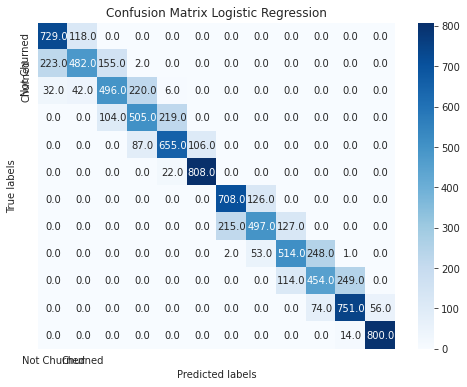

In [ ]:
import seaborn as sns

#plotting a confusion matrix
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_lr,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Logistic Regression');

K-Nearest neighbors

A K-Neighbors model has been implemented and tuned on the train set. The parameters tuned are:

Number of neighbors which will determine the number of points used to classify into each of the categories the data points
Two weighting systems to be tested: uniform and distance.
The number of neighbors when tuning the model has a range from 1 to 100.

In [ ]:
#Train model
# Initialize and fit the model.
KNN = KNeighborsClassifier()

#Tune hyperparameters
#Create range of values to fit parameters
k_range = list(range(1, 100))
weights = ['uniform', 'distance']

#Fit parameters
parameters = {'n_neighbors': k_range, 'weights': weights}

#Fit parameters using gridsearch
KNN_tuned = GridSearchCV(KNN, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
KNN_tuned.fit(X_train, y_train)

# Examine the best model
print(KNN_tuned.best_score_)
print(KNN_tuned.best_params_)
print(KNN_tuned.best_estimator_)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.3min


0.9954730354534777
{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:  3.1min finished


The value for "n_neighbors" is the smallest of the values chosen to tune the parameters of the model. In this case the gridsearch has been carried out with values ranging from 1 to 100.  1 was the value that was appearing as the best one in terms of overall accuracy. The choice fo distance as the weight instead of uniform is reasonable were the points are weighted by the inverse of their distance. 

In [ ]:
#Once the model has been trained test it on the test dataset
KNN_tuned.fit(X_test, y_test)

# Predict on test set
y_predtest_knn = KNN_tuned.predict(X_test)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:  1.0min finished


The tuned model is fit and run on the test set and the computational effort is measured considering the time required to fit the test set. It took 1 min to fit the test set. 

In [ ]:
#Evaluation of the model (testing)

#Define targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print classification report
print(('Classification Report KNN: \n {}\n').format(classification_report(y_test, y_predtest_knn, target_names=target_names)))

#Calculate confusion matrix
confusion_knn = confusion_matrix(y_test, y_predtest_knn)

#Print confusion matrix
print(('Confusion Matrix KNN: \n\n {}\n\n').format(confusion_knn))

#Print overall accuracy
print(('KNN accuracy: {0:.2f} %\n').format(cross_val_score(KNN_tuned, X_test, y_test,cv=kf).mean()*100))

Classification Report KNN: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       847
         1.0       1.00      1.00      1.00       862
         2.0       1.00      1.00      1.00       796
         3.0       1.00      1.00      1.00       828
         4.0       1.00      1.00      1.00       848
         5.0       1.00      1.00      1.00       830
         6.0       1.00      1.00      1.00       834
         7.0       1.00      1.00      1.00       839
         8.0       1.00      1.00      1.00       818
         9.0       1.00      1.00      1.00       817
        10.0       1.00      1.00      1.00       881
        11.0       1.00      1.00      1.00       814

    accuracy                           1.00     10014
   macro avg       1.00      1.00      1.00     10014
weighted avg       1.00      1.00      1.00     10014


Confusion Matrix KNN: 

 [[847   0   0   0   0   0   0   0   0   0   0   0]
 [  0 862   0   0   0   0  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   49.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   48.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   48.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   48.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   34.6s


KNN accuracy: 97.85 %



[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   48.8s finished


The overall accuracy is hight at 97.85%. The classification report and confusion matrix show overfitting as there will be some data points misclassified. 

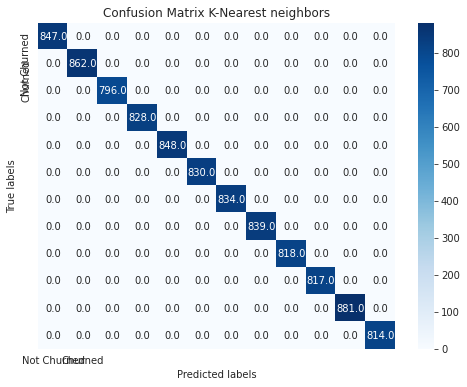

In [ ]:
import seaborn as sns

#plotting a confusion matrix
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_knn,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix K-Nearest neighbors');

Random Forest Model

The hyperparamters of the random forest model will be tuned. The parameters to be tuned are:

1.N_estimators determining the number of trees that will be part of the algorithm.
2.Max depth determining the size of the tree.

In [ ]:
# Initialize and fit the model.
rf = RandomForestClassifier()

#Tune hyperparameters
#Create range of values to fit parameters
n_estimators_param = np.arange(50,250,10)
max_depth_param = np.arange(1,50,5)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf_tuned = GridSearchCV(rf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf_tuned.fit(X_train, y_train)

# Examine the best model
print(rf_tuned.best_score_)
print(rf_tuned.best_params_)
print(rf_tuned.best_estimator_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 66.1min finished


0.9963051483582438
{'max_depth': 26, 'n_estimators': 160}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


The number of trees used is 160 being the depth of each tree 26. After several simulations, the parameters have stayed stable around these values. The random forest algorithm is an ensemble algorithm that works bringing together different decision trees and being more powerful than an individual decision tree.

In [ ]:
#Once the model has been trained test it on the test dataset
rf_tuned.fit(X_test, y_test)

# Predict on test set
y_predtest_rf = rf_tuned.predict(X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 24.9min finished


Once the parameters are tuned, the model is fit and run on the test set. As it can be seen from the hyperparameter tuning, the model requires much more time (computational effort) than the previous models. The increase in accuracy must justify the significant increase of time required to fit the model.

In [ ]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report RF: \n {}\n').format(classification_report(y_test, y_predtest_rf,target_names=target_names)))

#Calculate the confusion matrix
confusion_rf = confusion_matrix(y_test, y_predtest_rf)

#Print the confusion matrix
print(('Confusion Matrix RF: \n\n {}\n\n').format(confusion_rf))

#Print the overall accuracy
print(('Random Forest accuracy RF: {0:.2f} %\n').format(cross_val_score(rf_tuned, X_test, y_test, cv=kf).mean()*100))

Classification Report RF: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       847
         1.0       1.00      1.00      1.00       862
         2.0       1.00      1.00      1.00       796
         3.0       1.00      1.00      1.00       828
         4.0       1.00      1.00      1.00       848
         5.0       1.00      1.00      1.00       830
         6.0       1.00      1.00      1.00       834
         7.0       1.00      1.00      1.00       839
         8.0       1.00      1.00      1.00       818
         9.0       1.00      1.00      1.00       817
        10.0       1.00      1.00      1.00       881
        11.0       1.00      1.00      1.00       814

    accuracy                           1.00     10014
   macro avg       1.00      1.00      1.00     10014
weighted avg       1.00      1.00      1.00     10014


Confusion Matrix RF: 

 [[847   0   0   0   0   0   0   0   0   0   0   0]
 [  0 862   0   0   0   0   0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 21.0min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.8min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.7min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.5min finished


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.7min finished


Random Forest accuracy RF: 98.04 %



The overall accuracy is high at 98.04%. But there is a significant increase in the computational effort required by this algorithm as it was expected. The classification report and the classification matrix present overfitting as the precision in all cases is one and there are no misclassified elements. To avoid this overfitting problem, cross validation has been performed on the random forest but still couldn't eliminate the overfitting problem.

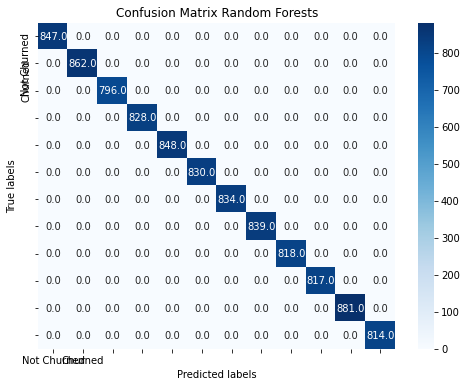

In [ ]:
import seaborn as sns

#plotting a confusion matrix
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_rf,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Random Forests');

Gradient Boosting Model
The hyperparamters of the gradient boosting classifier that are tuned are the same than in the case of the random forest. The parameters to be tuned are 

1. N_estimators determining the number of trees that will be part of the algorithm.
2. Max depth determining the size of the tree.

In [61]:
# Train model
GBC = GradientBoostingClassifier()

#Tune hyperparameters
#Create range of values to fit parameters

n_estimators_param = np.arange(120,200,10)
max_depth_param = np.arange(30,80,10)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters
GBC_tuned = GridSearchCV(GBC, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned model
GBC_tuned.fit(X_train, y_train)

#The best hyper parameters set
# Examine the best model
print(GBC_tuned.best_score_)
print(GBC_tuned.best_params_)
print(GBC_tuned.best_estimator_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 83.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 84.9min finished


0.9947073453290992
{'max_depth': 40, 'n_estimators': 130}
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=40,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=130,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In the case of Gradient boosting model, the data is passed over and over again tuning the parameters every time the data is passed. This is the reason why compared to the random forest it requires so much time. The number of trees is higher than the number of trees used in random forest and the depth is nearly doubling the one previously calculated for the random forest. In this case the computational effort has grown exponentially compared to other classifiers so it is expected that the accuracy is much higher than in the case of the logistic regression classifier to be a candidate for production.

In [62]:
GBC_tuned.fit(X_test, y_test)

# Predict on test set

y_predtest_gb = GBC_tuned.predict(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 31.1min finished


In this case, the algorithm uses the gradient descendent algorithm to follow the steepest path that reduces the loss.As in the case of Random Forest, this classifier presents overfitting in the classification report and confusion matrix. To reduce the overfitting cross validation is applied.

In [63]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report: \n {}\n').format(classification_report(y_test, y_predtest_gb,target_names=target_names)))

#Calculate the confusion matrix
confusion_GBC = confusion_matrix(y_test, y_predtest_gb)

#Print the confusion matrix
print(('Confusion Matrix: \n\n {}\n\n').format(confusion_GBC))

#Print the overall accuracy
print(( 'Gradient Boosting Classifier accuracy: {0:.2f} %\n').format(cross_val_score(GBC_tuned, X_test, y_test,cv=kf).mean()*100))

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       847
         1.0       1.00      1.00      1.00       862
         2.0       1.00      1.00      1.00       796
         3.0       1.00      1.00      1.00       828
         4.0       1.00      1.00      1.00       848
         5.0       1.00      1.00      1.00       830
         6.0       1.00      1.00      1.00       834
         7.0       1.00      1.00      1.00       839
         8.0       1.00      1.00      1.00       818
         9.0       1.00      1.00      1.00       817
        10.0       1.00      1.00      1.00       881
        11.0       1.00      1.00      1.00       814

    accuracy                           1.00     10014
   macro avg       1.00      1.00      1.00     10014
weighted avg       1.00      1.00      1.00     10014


Confusion Matrix: 

 [[847   0   0   0   0   0   0   0   0   0   0   0]
 [  0 862   0   0   0   0   0   0  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.5min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.2min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.5min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.2min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.3min finished


Gradient Boosting Classifier accuracy: 97.25 %



The overall accuracy is high at 97.25%. The same principle regarding the feature selection applies than in the case of random forest so it is not strange to find in this case an overall accuracy close to the one obtained with random forest. The classification report and the classification matrix present overfitting as the precision in all cases is one and there are no misclassified elements. In the implementation of the descendent gradient over the random forest algorithm has not significantly improved the accuracy while it has increased the computational effort required to achieve it. Hence, this algorithm is not used for production.

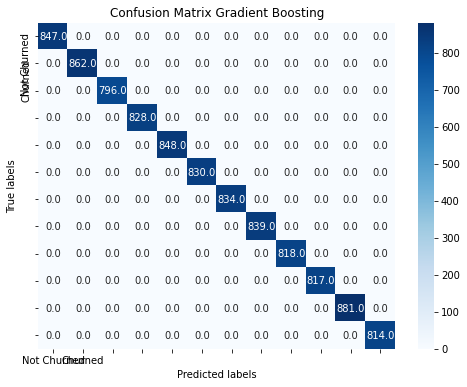

In [64]:
import seaborn as sns

#plotting a confusion matrix
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_GBC,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Gradient Boosting');

Support Vector Classifier (SVM) 
A support vector classifier has been set up and tuned on the training data and run on the test set. The hyperparameters that have been tuned are:

C parameter, acting on the margin hyperplane having a bigger margin when C is smaller.

In [129]:
# Train model
# Initialize and fit the model. 
svc = SVC(class_weight='balanced')

#Tune hyperparameters
#Create range of values to fit parameters

C_param = [10,100,1000]

#Fit parameters
parameters = {'C': C_param}

#Fit parameters using gridsearch
svc_tuned = GridSearchCV(svc, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
svc_tuned.fit(X_train, y_train)

#The best hyper parameters set
print(svc_tuned.best_score_)
print(svc_tuned.best_params_)
print(svc_tuned.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   43.5s finished


0.977631283877557
{'C': 1000}
SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


The time required to tune the parameters has been lower than expected especially for a dataset as large as ours. The use of a high C aims to classify the training examples correctly by selecting more samples as support vectors. In this case, the use of PCA helps to set up the boundaries using data that has been preprocessed to explain the maximum possible variance by rotating it. The model is fit in the test set.

In [130]:
#Fit tunned model on Test set
svc_tuned.fit(X_test, y_test)

# Predict on training set
y_predtest_svc = svc_tuned.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.0s finished


In [131]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report: \n {}\n').format(classification_report(y_test, y_predtest_svc, target_names=target_names)))

#Calculate the confusion matrix
confusion_SVC = confusion_matrix(y_test, y_predtest_svc)

#Print the confusion matrix
print(('Confusion Matrix: \n\n {}\n\n').format(confusion_SVC))

#Print the overall accuracy
print(( 'SVC accuracy: {0:.2f} %\n').format(cross_val_score(svc_tunned, X_test, y_test,cv=kf).mean()*100))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       847
         1.0       0.98      0.97      0.98       862
         2.0       0.95      0.94      0.95       796
         3.0       0.92      0.95      0.93       828
         4.0       0.97      0.95      0.96       848
         5.0       0.99      0.99      0.99       830
         6.0       0.99      0.99      0.99       834
         7.0       0.98      0.99      0.98       839
         8.0       0.98      0.98      0.98       818
         9.0       0.98      0.98      0.98       817
        10.0       1.00      0.99      0.99       881
        11.0       1.00      1.00      1.00       814

    accuracy                           0.98     10014
   macro avg       0.98      0.98      0.98     10014
weighted avg       0.98      0.98      0.98     10014


Confusion Matrix: 

 [[842   5   0   0   0   0   0   0   0   0   0   0]
 [ 11 835  16   0   0   0   0   0  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.9s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.9s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.9s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.8s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.7s finished


SVC accuracy: 96.33 %



In this case the accuracy obtained is 96.33% which is close to the one obtained with the Random Forest and Gradient Boosting models  but it requires less computational effort. This is due to the transformation done when preprocessing the data with PCA as the kernel trick requires less time (the data is already in the axis that maximize the variance) than expected and therefore less computational power. Also, based on the Classification report and Confusion Matrix, the model doesn't suffer from overfitting concerns. .This is a strong candidate to go into production if the PCA is maintained before the algorithm is run as otherwise the time will increase quadratic (as complexity). 



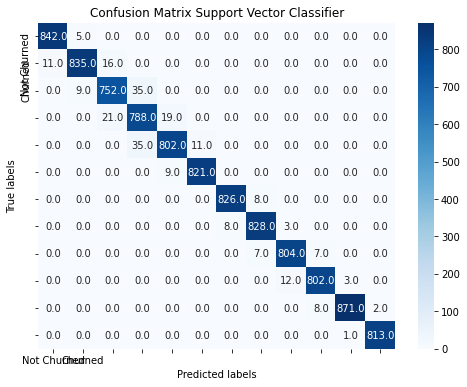

In [133]:
import seaborn as sns

#plotting a confusion matrix
labels = ['Not Churned', 'Churned']
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(confusion_SVC,cmap="Blues",annot=True,fmt='.1f', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Support Vector Classifier');

This model will be compared the deep learning classification results although this model is preferred as it allows to keep the features and requires less computational effort.

Summary:

1. Logistic Regression. Accuracy: 71.45%. Computing effort: 54.1s.
2. K-nearest neighbors. Accuracy: 97.85%. Computing effort: 1 min.
3. Random Forest. Accuracy: 98.04%. Computing effort: 24.9 min.
4. Gradient Boosting Classifier: Accuracy 97.25%. Computing effort: 31.1 min.
5. Support Vector Classifier. Accuracy: 96.33%. Computing effort: 8.0s.

From the abovementioned results the classifier that is good candidates to go into production is support vector machine. It presents low computational effort due to the transformation of the features that has been done during the features generation. But support vector machine presents scalability problems. So deep learning models are also tested. But the supervised models that have been tested here  are preferred as they allow to track back results to the most relevant features. Furthermore, they require less computational power and are less complex and more transparent form a custumer´s perspective.



###Deep Learning Classification Model

To carry out the multiclass classification based on demographics (gender and age) using the apps and brand of the device, a Deep Learning algorithm using Multilayer Perceptron has been built. In this case the data requires to be prepared so that it fits the MLP. The purpose of this MLP is to achieve higher accuracy than the supervised learning algorithms.

As the neural networks work better with scaled data, the processed data has been split into train and test with a 75/25 split. In this case it is not needed to produce the feature generation and selection to achieve high performance with the neural network so the preprocessed raw data is used.

In [69]:
#Split data in a train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X_normalized, y, test_size=0.25, random_state=42)

#Check the size of each of the sets.
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((30042, 276), (10014, 276), (30042,), (10014,))

To match the input requirements of the neural network, the dependent variable is transformed into a categorical sparse matrix. This matrix will have the same number of rows but will create one row per class used in the dependent vector.

In [70]:
# Convert class vectors to binary class matrices
# So instead of one column with 10 values, create 12 binary columns
y_train_mlp = keras.utils.to_categorical(y_tr, num_classes=12)
y_test_mlp = keras.utils.to_categorical(y_te, num_classes=12)

print(y_train_mlp.shape, y_test_mlp.shape)

(30042, 12) (10014, 12)


A gridsearchCV from sklearn can be used to tune the parameters for the neural network. In this case and due to computational restrictions, a trial and error approach has been selected. The process to build the model has been as follows.

1. Increased the number of layers and with it the batch size increasing the overall accuracy of the model
2. Increased the size of the hidden neural networks while increasing the dropout rate to reduce overfitting.
3. Increased the size of each layer up to 276 increasing the number of trainable parameters which improved the accuracy of the model.
4. Tried different activation functions but the preferred option from an accuracy standpoint is "relu" as it provides higher accuracy.
5. Used the batch normalization, normalized the input of each neural layer as part of the model architecture and performed the normalization in each mini batch. Both accuracy and speed improved when the batch normalization is used.
6. Increase the epochs giving time for the neural network to be trained increasing them from 50 to 250 and achieving better results when 200 epochs and 1250 batch size was used.
7. Different optimizers have been used: SGD and RMS, giving RMS a better accuracy than SGD when combined with batch normalization (Note: SGD eliminates the normalization done by the batch normalizer).

The model used is as follows. The input layer has the input dimension of the vector and 276 neurons. It has 5 hidden layers and the output layer has the dimension of the classification vector (12). Between each layer, the batch normalization is introduced to reduce the covariance shift and an additional dropout is introduced to reduce overfitting. Although the dropouts could be avoided by using the batch normalization, the preferred option is to introduce the dropout to avoid overfitting.

In [71]:
#Start the model
model = Sequential()

#Set up the outter layer
model.add(Dense(276, activation='relu', input_dim=276))

# Dropout layers remove features and fight overfitting
model.add(Dropout(0.5))
model.add(Dense(276, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(276, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(276, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(276, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(276, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(276, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))

#Model features
model.summary()   
    
# Compile the model to put it all together.
RMS = RMSprop()
model.compile(loss='categorical_crossentropy',optimizer= RMS,metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 276)               76452     
_________________________________________________________________
dropout_7 (Dropout)          (None, 276)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 276)               76452     
_________________________________________________________________
batch_normalization_6 (Batch (None, 276)               1104      
_________________________________________________________________
dropout_8 (Dropout)          (None, 276)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 276)               76452     
_________________________________________________________________
batch_normalization_7 (Batch (None, 276)              

After several trial and errors, the optimum batch size for the model and epochs are 1250 and 200 respectively. Once the model was trained on the train set is tested. 

In [74]:
#Run the model
model.fit(X_tr, y_train_mlp, epochs=200, verbose=1, batch_size=1250)

#Evaluate the model
score = model.evaluate(X_te, y_test_mlp, verbose=1)

#Print results
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
25/25 [==============================] - 0s 12ms/step - loss: 0.3869 - accuracy: 0.8473
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3785 - accuracy: 0.8532
Epoch 3/200
25/25 [==============================] - 0s 10ms/step - loss: 0.3733 - accuracy: 0.8536
Epoch 4/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3618 - accuracy: 0.8562
Epoch 5/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3870 - accuracy: 0.8434
Epoch 6/200
25/25 [==============================] - 0s 10ms/step - loss: 0.3564 - accuracy: 0.8601
Epoch 7/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3780 - accuracy: 0.8506
Epoch 8/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3910 - accuracy: 0.8462
Epoch 9/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3633 - accuracy: 0.8549
Epoch 10/200
25/25 [==============================] - 0s 9ms/step - loss: 0.3726 - accuracy: 0.8528
Epoch 

An overall accuracy of 85.21% is achieved. This accuracy is lower than the Supervised training models.So, Support vector machine model is the preferred candidate for production. The neural network gives good accuracy but does not allow to distinguish the explanatory power of each of the features that are used. This is not required during image or text recognition but is necessary for the purpose of this project. Furthermore, the model is far more complex than the previous one and requires more computational power once it is in production. For all these reasons, although the accuracy is good, the support vector machine models is still the best candidate for production.

###Unsupervised Learning (Clustering)

To have a better understanding of the potential clients and relationship between them unsupervised clustering will be carried out. In this case, K-means clustering is used to cluster the customers and extract meaningful information for the marketing team. Once the clustering is selected, the number of clusters will be selected and the information will be extracted. As in the case of supervised learning the PCA components will be used during the analysis.

In [103]:
#Delete column with device_id
df_cluster = df.drop('device_id', axis = 1)

#Delete columns that are all zeros
df_cluster = df_cluster.drop(df_cluster.columns[(df_cluster == 0).all()], axis = 1)

df_cluster = df_cluster.drop_duplicates()

#Print the first five rows of the new dataset
df_cluster.head()

,is_active,gender,age,group,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,label_id_17,label_id_22,label_id_24,label_id_26,label_id_27,label_id_29,label_id_30,label_id_31,label_id_32,label_id_33,label_id_35,label_id_36,label_id_38,label_id_39,label_id_40,label_id_42,label_id_43,label_id_44,label_id_46,label_id_47,label_id_51,label_id_54,label_id_57,label_id_58,label_id_59,label_id_61,label_id_64,label_id_66,...,phone_brand_desci,phone_brand_dowe,phone_brand_epai,phone_brand_fks,phone_brand_google,phone_brand_greeno,phone_brand_haier,phone_brand_hammer,phone_brand_hasse,phone_brand_hisense,phone_brand_ipair,phone_brand_kiwu,phone_brand_koobee,phone_brand_kupo,phone_brand_lenovo,phone_brand_lingyun,phone_brand_lshi,phone_brand_meitu,phone_brand_mengmi,phone_brand_micky,phone_brand_moto,phone_brand_newman,phone_brand_nibilu,phone_brand_nokia,phone_brand_nubia,phone_brand_nuomi,phone_brand_obi,phone_brand_oneplus,phone_brand_ouxin,phone_brand_panasonic,phone_brand_samsung,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1,M,19.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,M,60.0,M39+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,M,28.0,M27-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,M,26.0,M23-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,M,22.0,M22-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
#Drop gender, age and group for the analysis and obtain the information describing the dataset as we are more interested in the phone brand and information reagrding the apps.
df_cluster= df.drop(['gender','age','group'],axis=1)

#Extract information
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 617 entries, is_active to phone_brand_yuxin
dtypes: Sparse[int64, 0](615), int64(2)
memory usage: 909.9 KB


A copy of the dataset will be done and the information will be normalized. This will improve the performance of clustering. Normalize the data. Standardize to bring all features to the same scale i.e. mean to zero and the standard deviation to 1.

In [105]:
scaler = StandardScaler()
scaler.fit(df_cluster)
X_std = scaler.transform(df_cluster)
df_norm = pd.DataFrame(X_std, columns=df_cluster.columns)
df_norm.head()

,is_active,device_id,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,label_id_9,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,label_id_17,label_id_18,label_id_19,label_id_20,label_id_21,label_id_22,label_id_23,label_id_24,label_id_25,label_id_26,label_id_27,label_id_29,label_id_30,label_id_31,label_id_32,label_id_33,label_id_35,label_id_36,label_id_37,label_id_38,label_id_39,label_id_40,label_id_41,label_id_42,label_id_43,label_id_44,...,phone_brand_greeno,phone_brand_haier,phone_brand_hammer,phone_brand_hasse,phone_brand_heymi,phone_brand_hisense,phone_brand_ipair,phone_brand_kiwu,phone_brand_koobee,phone_brand_kupo,phone_brand_lenovo,phone_brand_lingyun,phone_brand_lshi,phone_brand_meitu,phone_brand_mengmi,phone_brand_micky,phone_brand_mige,phone_brand_mole,phone_brand_moto,phone_brand_newman,phone_brand_nibilu,phone_brand_nokia,phone_brand_nubia,phone_brand_nuomi,phone_brand_obi,phone_brand_oneplus,phone_brand_ouxin,phone_brand_panasonic,phone_brand_pner,phone_brand_samsung,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1.000086,0.279750,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.006553,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426
1,1.000086,1.348179,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.006553,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426
2,1.000086,-0.645253,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.006553,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426
3,1.000086,-1.225984,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.006553,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426
4,1.000086,-1.056314,0.0,0

In [106]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(df_norm)

In [107]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    pca_components,
    test_size=0.5,
    random_state=42)

In [108]:
ypred=pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 10.
    for nclust in range(2, 10):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

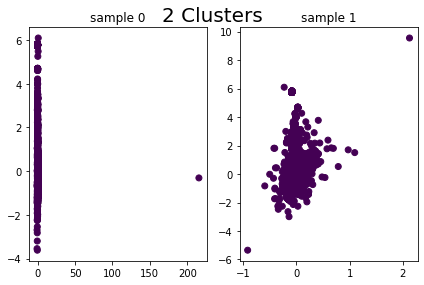

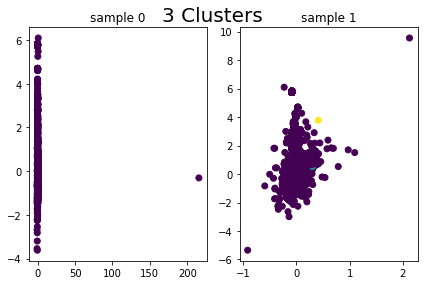

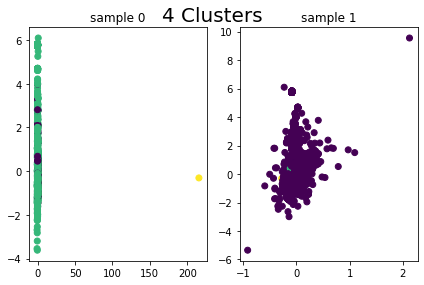

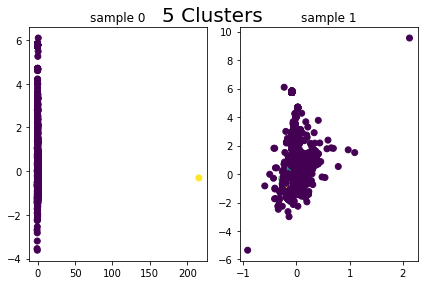

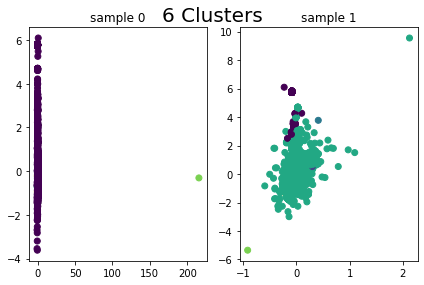

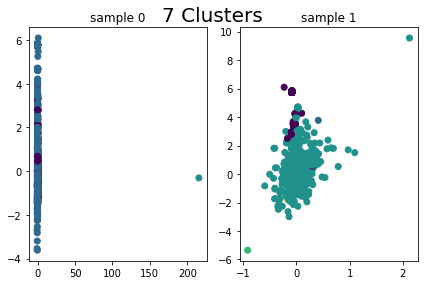

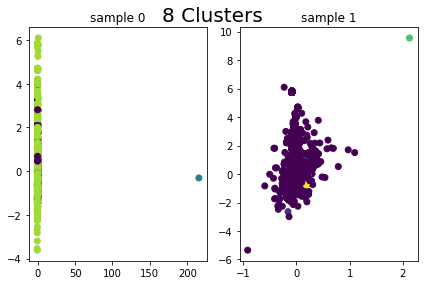

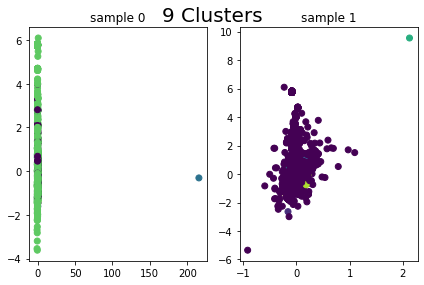

In [109]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 10):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

From the PCA plots, sample 0 is not useful but some delineation between the clusters can be seen in sample 1. Ignoring the colors, consistency seems slightly better for 5 and 6 clusters. Use Elbow plot to find optimum number of clusters. 

Elbow plot

In [110]:
from sklearn.cluster import KMeans

# Let's find the optimal number of clusters using the Elbow method
PCA_components = pd.DataFrame(pca_components)

wcss = []
for i in range(1,11):
    # Create a KMeans model with k clusters
    kmeans = KMeans(n_clusters=i)
    
    # Fit model to samples
    kmeans.fit(PCA_components.iloc[:,:3])
    
    # Append the wcss (inertia) to the lis
    wcss.append(kmeans.inertia_)

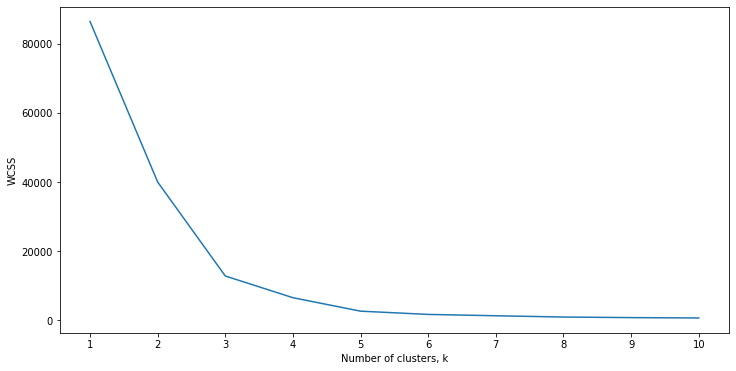

In [200]:
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss)
plt.xticks(np.arange(1,11,step=1))
plt.xlabel('Number of clusters, k')
plt.ylabel('WCSS')
plt.show()

From the plot, it looks like the optimal number of clusters is 5 (or) 6. Compare the silhoutte scores for n= 2 to 10 clusters. 

In [202]:
from sklearn import metrics

In [203]:
pred_2 = KMeans(n_clusters=2, random_state=42).fit_predict(PCA_components)
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_2, metric='euclidean')))

Silhouette score for two cluster k-means: 0.9946408227606234


In [204]:
pred_3 = KMeans(n_clusters=3, random_state=42).fit_predict(PCA_components)
print("Silhouette score for three cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_3, metric='euclidean')))

Silhouette score for three cluster k-means: 0.8065413336499465


In [205]:
pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(PCA_components)
print("Silhouette score for four cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_4, metric='euclidean')))

Silhouette score for four cluster k-means: 0.5968827419600141


In [206]:
pred_5 = KMeans(n_clusters=5, random_state=42).fit_predict(PCA_components)
print("Silhouette score for five cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_5, metric='euclidean')))

Silhouette score for five cluster k-means: 0.607301665188154


In [207]:
pred_6 = KMeans(n_clusters=6, random_state=42).fit_predict(PCA_components)
print("Silhouette score for six cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_6, metric='euclidean')))

Silhouette score for six cluster k-means: 0.5833555801216759


In [208]:
pred_7 = KMeans(n_clusters=7, random_state=42).fit_predict(PCA_components)
print("Silhouette score for seven cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_7, metric='euclidean')))

Silhouette score for seven cluster k-means: 0.5853593555626113


In [209]:
pred_8 = KMeans(n_clusters=8, random_state=42).fit_predict(PCA_components)
print("Silhouette score for eight cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_8, metric='euclidean')))

Silhouette score for eight cluster k-means: 0.5776939353458085


In [210]:
pred_9 = KMeans(n_clusters=9, random_state=42).fit_predict(PCA_components)
print("Silhouette score for nine cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_9, metric='euclidean')))

Silhouette score for nine cluster k-means: 0.5492459631814862


In [211]:
pred_10 = KMeans(n_clusters=10, random_state=42).fit_predict(PCA_components)
print("Silhouette score for ten cluster k-means: {}".format(metrics.silhouette_score(PCA_components, pred_10, metric='euclidean')))

Silhouette score for ten cluster k-means: 0.5543407343792376


The best number of clusters from both the silhouette and the elbow technique perspective is 5 (Silhoutte score of 0.6) that will be used to cluster the popular phone brands. The data will be clustered using kmeans and 5 clusters to get insights about label ids and popular phone brands for application.

In [111]:
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit model.
%timeit kmeans.fit(PCA_components)
y_pred = kmeans.predict(PCA_components)

1 loop, best of 3: 210 ms per loop


It took 232 ms to train the K-Means model with PCA and n_clusters=5.

Application

In [112]:
df_norm['cluster'] = kmeans.labels_

In [113]:
#Look at the dataframe with the cluster labels attached
df_norm.head()

,is_active,device_id,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,label_id_9,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,label_id_17,label_id_18,label_id_19,label_id_20,label_id_21,label_id_22,label_id_23,label_id_24,label_id_25,label_id_26,label_id_27,label_id_29,label_id_30,label_id_31,label_id_32,label_id_33,label_id_35,label_id_36,label_id_37,label_id_38,label_id_39,label_id_40,label_id_41,label_id_42,label_id_43,label_id_44,...,phone_brand_haier,phone_brand_hammer,phone_brand_hasse,phone_brand_heymi,phone_brand_hisense,phone_brand_ipair,phone_brand_kiwu,phone_brand_koobee,phone_brand_kupo,phone_brand_lenovo,phone_brand_lingyun,phone_brand_lshi,phone_brand_meitu,phone_brand_mengmi,phone_brand_micky,phone_brand_mige,phone_brand_mole,phone_brand_moto,phone_brand_newman,phone_brand_nibilu,phone_brand_nokia,phone_brand_nubia,phone_brand_nuomi,phone_brand_obi,phone_brand_oneplus,phone_brand_ouxin,phone_brand_panasonic,phone_brand_pner,phone_brand_samsung,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin,cluster
0,1.000086,0.279750,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426,4
1,1.000086,1.348179,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426,4
2,1.000086,-0.645253,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426,4
3,1.000086,-1.225984,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,-0.014654,0.0,0.0,0.0,0.0,-0.039346,0.0,-0.014654,0.0,-0.013106,-0.013106,-0.01135,-0.01135,-0.009267,-0.013106,-0.006553,-0.006553,-0.013106,0.0,-0.006553,-0.006553,-0.006553,0.0,-0.030749,-0.01135,-0.025386,...,-0.009267,-0.068572,-0.009267,0.0,-0.039346,-0.01135,-0.006553,-0.014654,-0.009267,-0.15494,-0.014654,-0.140365,-0.030041,-0.01135,-0.009267,0.0,0.0,-0.032118,-0.018537,-0.018537,-0.017339,-0.089968,-0.006553,-0.009267,-0.054906,-0.006553,-0.013106,0.0,-0.404796,0.0,-0.27604,-0.01135,-0.014654,-0.009267,-0.006553,-0.009267,-0.014654,-0.019662,-0.040426,4
4,1.000086,-1.056314,0.0,0.0,-0.009267,0.0,-0.021738,0.0,-0.006553,-0

In [51]:
filter_col = [col for col in df_norm if col.startswith('label_id')]

#Determine pivot table
df_norm = df_norm.pivot_table(values=filter_col, index=["cluster"], aggfunc=np.sum)

#Print the label_id that appears more times
print(df_norm.idxmax(axis=1))

cluster
0    label_id_130
1    label_id_548
2    label_id_969
3    label_id_706
4    label_id_713
dtype: object


Information regarding the apps that people use is obtained from the clusters. It can be seen the most used ones across clusters App 130, 548, 969, 706 and 713 that according to the documentation equate to Online Shopping navigation, Industry tag, Casual games, Low Risk, and Antique collection. 

In [114]:
filter_col = [col for col in df_norm if col.startswith('phone_brand')]

#Determine pivot table
df_norm = df_norm.pivot_table(values=filter_col, index=["cluster"], aggfunc=np.sum)

#Print the phone_brand that appears more times
print(df_norm.idxmax(axis=1))

cluster
0    phone_brand_Xiaomi
1     phone_brand_ouxin
2      phone_brand_OPPO
3      phone_brand_OPPO
4     phone_brand_Meizu
dtype: object


For the Phone brands, it appears that Xiaomi, ouxin, OPPO, and Meizu are the most popular ones. 

From the unsupervised clustering analysis, it can be seen that clusters are not stable as every time that the “elbow” test was run different results were given which influenced the number of clusters to be used with k-means. Furthermore, the performance is low for classification purposes. 

For future work, other Clustering methods can be tested to see if it's suitable for this product. 



###Conclusion

The purpose of this project is to classify a subset of the population of China that uses a mobile operator based on the apps they have installed and that they used and the brand of the device they have. The classification takes into consideration gender and age range. The groups are distributed as follows (M=male, F=female being digits age limits): 'M39+' , 'M32-38', 'M29-31', 'M27-28', 'M23-26', 'M22-', 'F43+' ,'F33-42', 'F29-32', 'F27-28', 'F24-26', 'F23-'. This demographic classification will allow the mobile operator “Talking Data” to sell added value services to marketing agencies and other companies so that they can improve the targeting of their marketing campaigns. Additionally it can be used to determine the most popular apps and brands. 

For the analysis, datasets available in Kaggle have been used. The different files were scattered in different excel spreadsheet and the data was mainly categorical. The first action that has been done has been to merge into one dataset the relevant data required to build the classification models. In this case, information such as timestamp and longitude and latitude has been excluded due to its quality. In most of the instances the data was either incomplete or incorrect. The different datasets have been merged using the device_id as link between the dfferent demographic groups (containing information about gender and age range) apps and brand. Prior to being merged, dummy variables have been created and duplicates eliminated to avoid a disproportionate growth of the final dataset.

Exploratory data analysis shows how the number of apps active is roughly 50% of the apps installed. The population is concentrated in a range between 20 and 35 and that the age distribution. From an apps perspective, most of them have to do with financial products, banking and industrial (construction). From a brand perspective eight brands represent 90% of the sample in the Chinese market (Xaomi, Samsung, Huawei, Vivo, OPPO, Meizu, Coldpad, Lenovo, Gionee). There is inequality in terms of gender distribution being the female users half the male users. 

The different groups are unbalanced therefore resampling of the data has been done to avoid bias on the different classifiers that are used. This has increased the dataset to 40k rows manageable with the computing power available at google Colab. 

Features have been generated following features selection techniques such as SelectKkbest after standardizing and normalizing the data. The number of features has been selected following PCA (in this case n=5 components is used that explains maximum variance in the dataset).

Model selection has been carried out splitting the sample into 75/25 training on 75% of the data (once transformed through PCA). Models have been trained and tuned using gridsearch and cross validation with five folds has been used to test them. Accuracy has been set as the main scoring parameter as there is no difference regarding false positive or negatives. The models, accuracy and computing effort (based in time required to fit the test set) are summarized below:

1. Logistic Regression. Accuracy: 71.45%. Computing effort: 54.1s.
2. K-nearest neighbors. Accuracy: 97.85%. Computing effort: 1 min.
3. Random Forest. Accuracy: 98.04%. Computing effort: 24.9 min.
4. Gradient Boosting Classifier: Accuracy 97.25%. Computing effort: 31.1 min.
5. Support Vector Classifier. Accuracy: 96.33%. Computing effort: 8.0s.

From the abovementioned results the classifier that is a good candidates to go into production is support vector machine. It presents low computational effort due to the transformation of the features that has been done during the features generation. But support vector machine presents scalability problems. So deep learning models are also tested. But the supervised models that have been tested here are preferred as they allow to track back results to the most relevant features. Furthermore, they require less computational power and are less complex and more transparent form a custumer´s perspective.

Deep learning algorithms have been tested on the original normalized data and PCA. The choice has been to consider the original processed data as there was no significant differences in accuracy and neural networks are able to handle the data and generate the best features.

Different configurations of a neural network have been passed to achieve a higher accuracy than the Supervised Learning models. In this case, the final configuration of the Multi-Layer Perceptron that achieves 85.21% is a sequential neural network with 6 hidden layer of 276 neurons and a dropout rate of 0.5 using batch normalization between layers. The activation function is “relu”, the loss is categorical crossentropy and the optimizer RMS. In this case, batches of 1250 have been used and 200 epochs have been used to optimize the accuracy of the model.

This accuracy is lower than the Supervised training models. So, Support vector machine model is still the preferred candidate for production. The neural network gives good accuracy but does not allow to distinguish the explanatory power of each of the features that are used. This is not required during image or text recognition but is necessary for the purpose of this project. Furthermore, the model is far more complex than the previous one and requires more computational power once it is in production. For all these reasons, although the accuracy is good, the support vector machine models is still the best candidate for production.

Unsupervised Learning was carried out to have a better understanding of the potential clients and relationship between them unsupervised clustering was carried out. In this case, K-means clustering is used to cluster the customers and extract meaningful information for the marketing team. Once the clustering is selected, the number of clusters will be selected and the information was extracted. As in the case of supervised learning the PCA components was used during the analysis.

From the PCA plots, some delineation between the clusters were seen. Ignoring the colors, consistency seems slightly better for 5 and 6 clusters. Elbow plot was used to find optimum number of clusters. From the Elbow plot, it looks like the optimal number of clusters is 5 (or) 6. Compared the silhoutte scores for n= 2 to 10 clusters. The best number of clusters from both the silhouette and the elbow technique perspective is 5 (Silhoutte score of 0.6) that was used to cluster the popular phone brands. It took 232 ms to train the K-Means model with PCA and n_clusters=5. The data was clustered using kmeans and 5 clusters to get insights about label ids and popular phone brands for application.

Further analysis, information regarding the apps that people use was obtained from the clusters. It can be seen the most used ones across clusters App 130, 548, 969, 706 and 713 that according to the documentation equate to Online Shopping navigation, Industry tag, Casual games, Low Risk, and Antique collection. For the Phone brands, it appears that Xiaomi, ouxin, OPPO, and Meizu are the most popular ones.

From the unsupervised clustering analysis, it can be seen that clusters are not stable as every time that the “elbow” test was run different results were given which influenced the number of clusters to be used with k-means. Furthermore, the performance is low for classification purposes. For future work, other Clustering methods can be tested to see if it's suitable for this product.

Due to the characteristics of the data and high dimensionality of the problem the plots of the clusters is highly scattered which does not give much relevant information about them. Hence, from a classification purpose the best model to use based on its accuracy is Support Vector Machines which can compete in terms of accuracy with deep learning models and is a better candidate for production. From a clustering perspective, clustering is not offering much relevant information and cannot be used for classification.